# Final Experiments - Single-label MNB - CPU

## Utilities and Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_multi_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5s, top10s = mapt(make_text_dataset, [top5s, top10s])

In [3]:
print(top5s[1][5])
print(len(top5s[0]))
print(Counter(top5s[1]).most_common())

dp
550
[('data structures', 110), ('implementation', 110), ('dp', 110), ('math', 110), ('greedy', 110)]


In [4]:
top5s[0][4]

"A. Water The Garden\ntime limit per test1 second\nmemory limit per test256 megabytes\ninputstandard input\noutputstandard output\nIt is winter now, and Max decided it's about time he watered the garden.\nThe garden can be represented as n consecutive garden beds, numbered from 1 to n. k beds contain water taps (i-th tap is located in the bed xi), which, if turned on, start delivering water to neighbouring beds. If the tap on the bed xi is turned on, then after one second has passed, the bed xi will be watered; after two seconds have passed, the beds from the segment [xi\u2009-\u20091,\u2009xi\u2009+\u20091] will be watered (if they exist); after j seconds have passed (j is an integer number), the beds from the segment [xi\u2009-\u2009(j\u2009-\u20091),\u2009xi\u2009+\u2009(j\u2009-\u20091)] will be watered (if they exist). Nothing changes during the seconds, so, for example, we can't say that the segment [xi\u2009-\u20092.5,\u2009xi\u2009+\u20092.5] will be watered after 2.5 seconds h

## MNB Definitions

In [5]:
mnb = SKModel(Pipeline(
    [('countvec', CountVectorizer(stop_words=stop_words)),
    ('clf', MultinomialNB())]),
    {'countvec__max_df': (0.25, 0.5, 0.75),
     'countvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
     'clf__alpha': [0.25, 0.5, 0.75, 1]}) 
mnb = MWrapper(mnb, 'mnb')

Note: Model directory for mnb exists.


## Experiments

### 5-class experiments

In [6]:
trunner = TextRunner([mnb], top5s[0], top5s[1], 'top5s', make_pyt_data=False)
Xall, yall = np.array(trunner.rdata), np.array(trunner.labels)

Checkpoint reached: raw data cleaned.
multiclass classification.


In [32]:
runs = 1
out_dim = 5

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        clf, score = trunner.get_clf_sk(mnb, X_train, y_train)
        preds = clf.predict(X_test)
        preds_txt.append(preds)
        targs_txt.append(y_test)

        print(accuracy_score(np.concatenate(targs_txt),
                             np.concatenate(preds_txt)))

preds_txt = np.concatenate(preds_txt)
targs_txt = np.concatenate(targs_txt)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.2s finished


0.4909090909090909
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.3s finished


0.4727272727272727
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.2s finished


0.509090909090909
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.1s finished


0.4863636363636364
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.4s finished


0.5018181818181818
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.8s finished


0.49696969696969695
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.7s finished


0.4805194805194805
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.6s finished


0.48863636363636365
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.8s finished


0.48484848484848486
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   14.7s finished


0.4763636363636364


In [8]:
# pickle.dump([preds_txt, targs_txt], open('data/results/mnb_5s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/mnb_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures       0.57      0.78      0.66       110
             dp       0.37      0.47      0.42       110
         greedy       0.39      0.42      0.41       110
 implementation       0.48      0.28      0.35       110
           math       0.61      0.43      0.50       110

    avg / total       0.48      0.48      0.47       550

0.4763636363636364
0.46744993722142353
Normalized confusion matrix
[[0.78182 0.08182 0.04545 0.03636 0.05455]
 [0.18182 0.47273 0.19091 0.09091 0.06364]
 [0.10909 0.27273 0.41818 0.13636 0.06364]
 [0.13636 0.24545 0.24545 0.28182 0.09091]
 [0.16364 0.2     0.16364 0.04545 0.42727]]
0.7818181818181819


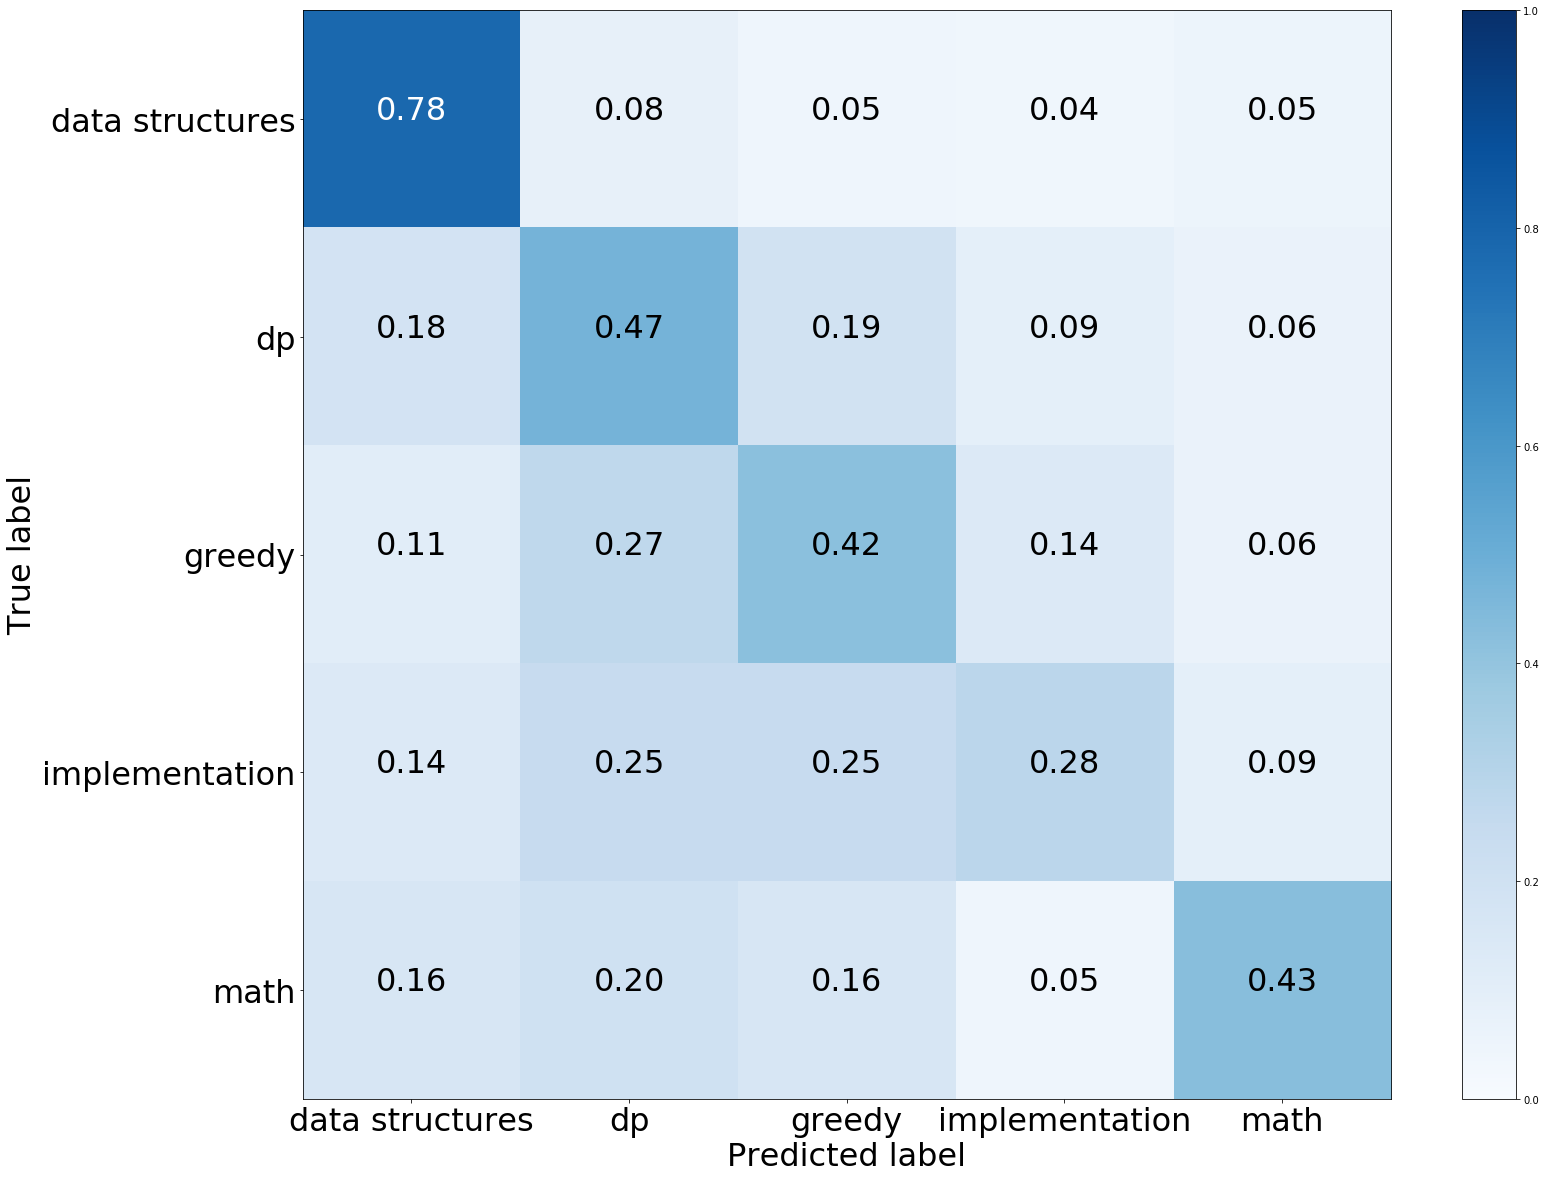

In [11]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)

### 10-class experiments

In [12]:
trunner = TextRunner([mnb], top10s[0], top10s[1], 'top10s', make_pyt_data=False)
Xall, yall = np.array(trunner.rdata), np.array(trunner.labels)

Checkpoint reached: raw data cleaned.
multiclass classification.


In [37]:
runs = 1

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        clf, score = trunner.get_clf_sk(mnb, X_train, y_train)
        preds = clf.predict(X_test)
        preds_txt.append(preds)
        targs_txt.append(y_test)

        print(accuracy_score(np.concatenate(targs_txt),
                             np.concatenate(preds_txt)))

preds_txt = np.concatenate(preds_txt)
targs_txt = np.concatenate(targs_txt)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.4s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   25.1s finished


0.39655172413793105
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   24.4s finished


0.4396551724137931
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   25.6s finished


0.4339080459770115
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   24.7s finished


0.43103448275862066
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   25.4s finished


0.4224137931034483
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   24.7s finished


0.4281609195402299
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.4s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   24.7s finished


0.43226600985221675
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   25.0s finished


0.4353448275862069
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.1s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   24.5s finished


0.43582375478927204
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.3s
[Parallel(n_jobs=5)]: Done 108 out of 108 | elapsed:   25.0s finished


0.43917169974115616


In [13]:
# pickle.dump([preds_txt, targs_txt], open('data/results/mnb_10s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/mnb_10s.pkl', 'rb'))

                         precision    recall  f1-score   support

            brute force       0.00      0.00      0.00        65
constructive algorithms       0.50      0.05      0.09        64
        data structures       0.54      0.47      0.50       110
                     dp       0.40      0.31      0.35       144
        dfs and similar       0.00      0.00      0.00        36
               geometry       0.73      0.33      0.45        49
                 greedy       0.27      0.12      0.16       121
         implementation       0.44      0.86      0.58       405
                   math       0.48      0.21      0.29       132
                strings       0.67      0.06      0.11        33

            avg / total       0.41      0.44      0.37      1159

0.43917169974115616
0.37119244265117496
Normalized confusion matrix
[[0.      0.      0.04615 0.09231 0.      0.      0.07692 0.75385 0.03077 0.     ]
 [0.      0.04688 0.09375 0.03125 0.01562 0.01562 0.0625  0.70312 

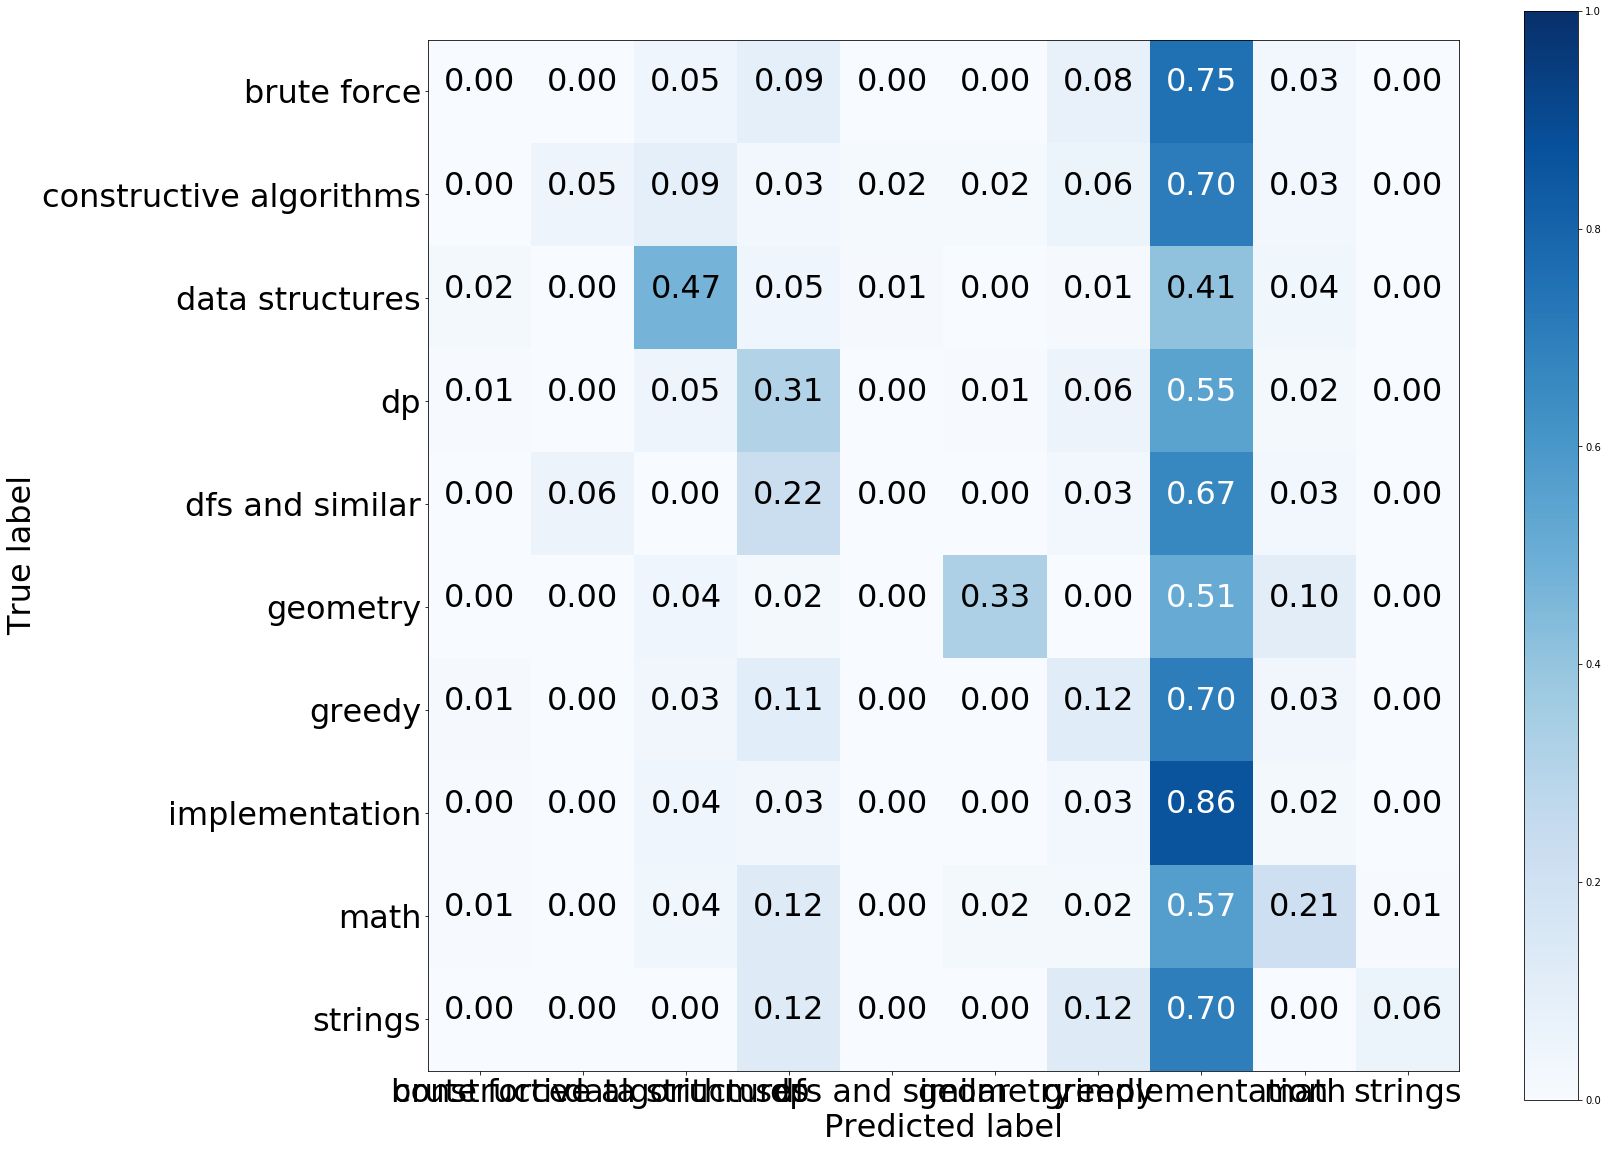

In [15]:
labels = ['brute force', 'constructive algorithms', 'data structures',
          'dp', 'dfs and similar', 'geometry', 'greedy',
          'implementation', 'math', 'strings']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)